In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from utils import plot_images, load_embeddings_and_ids
from Networks import ContentBasedLearn2RankNetwork_Evaluation

###  Load pre-trained image embeddings

In [2]:
youtube_embeddings,\
artwork_ids,\
artwork_id2index = load_embeddings_and_ids(
'/mnt/workspace/Ugallery/Youtube-like/v3_hidelast_usermodelbigger/', 'embeddings.npy', 'ids')

In [3]:
n_artworks = len(artwork_ids)
n_artworks

13297

In [4]:
youtube_embeddings.shape

(13297, 128)

### Testing Network

In [5]:
MODEL_PATH = '/mnt/workspace/pamessina_models/ugallery/youtube_like/v3_hidelast_usermodelbigger/'

In [6]:
image_cache = dict()

In [7]:
all_indexes = list(range(n_artworks))

In [8]:
def get_recommendation(profile_indexes, topk=10):    
    candidate_indexes = set(random.sample(all_indexes, 1000))
    candidate_indexes.update(profile_indexes)
    candidate_indexes = list(candidate_indexes)
    with tf.Graph().as_default():      
        network = ContentBasedLearn2RankNetwork_Evaluation(user_model_mode='BIGGER')
        with tf.Session() as sess:
            saver = tf.train.Saver()            
            saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH))
            match_scores = network.get_match_scores(sess, youtube_embeddings, profile_indexes, candidate_indexes)
            tuples = [(s,i) for i,s in zip(candidate_indexes, match_scores)]
            tuples.sort(reverse=True)
            return [tuples[i][1] for i in range(topk)]

In [19]:
profile_indexes = random.sample(all_indexes, 3)
profile_ids = [artwork_ids[i] for i in profile_indexes]
rec = get_recommendation(profile_indexes, topk=10)
rec_ids = [artwork_ids[i] for i in rec]
print('profile_indexes = ', profile_indexes)
print('profile_ids = ', profile_ids)
print('recommendation: ', rec_ids)

INFO:tensorflow:Restoring parameters from /mnt/workspace/pamessina_models/ugallery/youtube_like/v3_hidelast_usermodelbigger/
profile_indexes =  [607, 7398, 754]
profile_ids =  [47943, 49927, 38619]
recommendation:  [38619, 55341, 50251, 16704, 32995, 49926, 27209, 18536, 34683, 48887]


-------------------------------


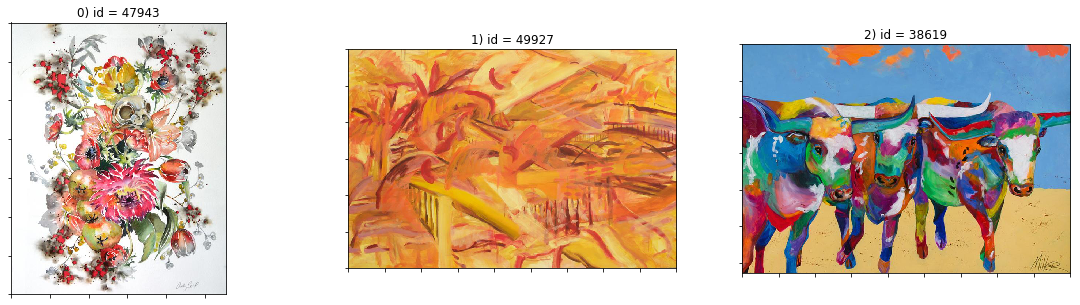

-------------------------------


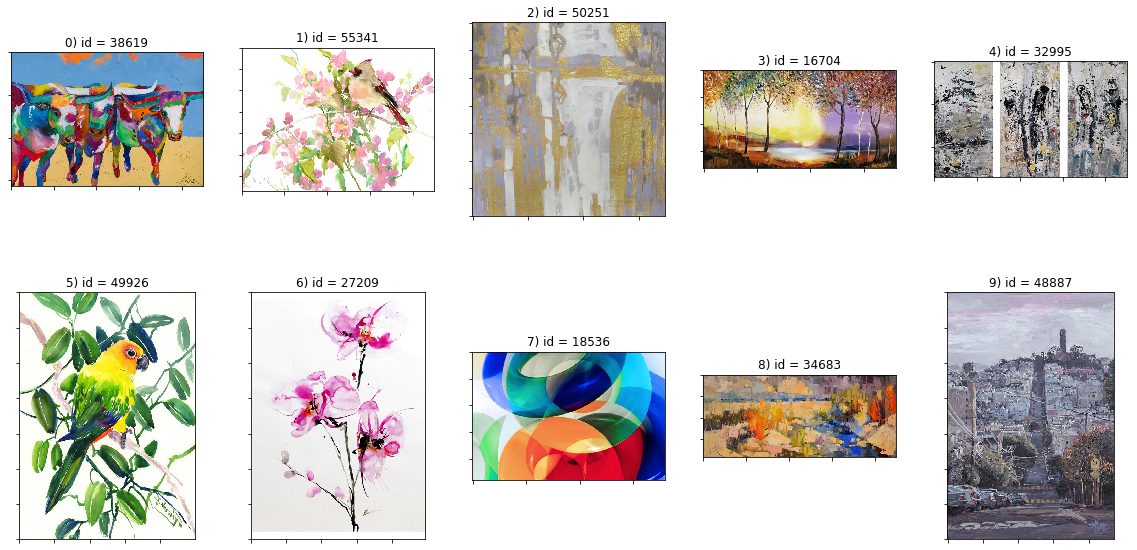

In [20]:
print('-------------------------------')
plot_images(plt, image_cache, profile_ids)
print('-------------------------------')
plot_images(plt, image_cache, rec_ids)